In [1]:
import pandas as pd
import os
import os.path, sys
import shutil
import glob
import numpy as np
import SimpleITK as sitk

# to query local databse
from mylocalbase import localengine
from sqlalchemy.orm import sessionmaker
import mylocaldatabase_new

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import numpy.ma as ma
from skimage.measure import find_contours, approximate_polygon

from scipy.spatial import Delaunay
from matplotlib.collections import LineCollection

# to save graphs
import six.moves.cPickle as pickle
import gzip

import networkx as nx
from parse_probmaps import querylocalDatabase_wRad

# Explore a nonmass Malignant

In [2]:
## Take a graph of a lesion for exploration
# 1_0002_6745896_zoomin_w4thpost_24slice_nonmassM
line='1_0002_6745896_right_2_1_NS_NF_probmap.mha'
processed_path = 'Y:\\Hongbo\\processed_data'
gt_path = 'Y:\\Hongbo\\gt_data'
graphs_path = 'Z:\\Cristina\\Section3\\breast_MR_pipeline\\graphs'
   
print(line)
fileline = line.split('_')
lesion_id = int(fileline[0] )
fStudyID = fileline[1] 
AccessionN = fileline[2]  
sideB = fileline[3]

#############################
###### 1) Querying Research database for clinical, pathology, radiology data
#############################
cond, BenignNMaligNAnt, Diagnosis, casesFrame, MorNMcase, lesion_coords = querylocalDatabase_wRad(lesion_id, verbose=False)       


1_0002_6745896_right_2_1_NS_NF_probmap.mha
Executing local connection...

 NON-MASS:

----------------------------------------------------------
InsituDuctal


E:\Users\DeepLearning\Anaconda2\Lib\site-packages\sqlalchemy\sql\sqltypes.py:562: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  'storage.' % (dialect.name, dialect.driver))


In [3]:
#############################
###### 2) Accesing mc images, prob maps, gt_lesions and breast masks
#############################
# get dynmic series info
DynSeries_id = MorNMcase['DynSeries_id']
precontrast_id = int(str(DynSeries_id[1:])) #s600, [1:] remove the 's'
DynSeries_nums = [str(n) for n in range(precontrast_id,precontrast_id+5)]

DynSeries_imagefiles = []
mriVols = []
print "Reading MRI volumes..."
for j in range(5):
    #the output mha:lesionid_patientid_access#_series#@acqusionTime.mha
    DynSeries_filename = '{}_{}_{}_{}'.format(str(lesion_id),fStudyID.zfill(4),AccessionN,DynSeries_nums[j] )

    #write log if mha file not exist             
    glob_result = glob.glob(os.path.join(processed_path,DynSeries_filename+'*')) #'*':do not to know the exactly acquistion time
    if glob_result != []:
        filename = glob_result[0]

    # add side info from the side of the lesion
    filename_wside = filename[:-4]+'_{}.mha'.format(sideB)
    DynSeries_imagefiles.append(filename_wside)

    # read Volumnes
    mriVols.append( sitk.GetArrayFromImage(sitk.Cast(sitk.ReadImage(DynSeries_imagefiles[j]),sitk.sitkFloat32)) )

#############################
###### 3) load graph object into memory
#############################
with gzip.open( os.path.join(graphs_path,'{}_{}_{}_lesion_querygraph.pklz'.format(str(lesion_id),fStudyID.zfill(4),AccessionN)), 'rb') as f:
    lesion_delaunay = pickle.load(f)

with gzip.open( os.path.join(graphs_path,'{}_{}_{}_allquerygraphs_Delatriang.pklz'.format(str(lesion_id),fStudyID.zfill(4),AccessionN)), 'rb') as f:
    alls_queryg_delaunay = pickle.load(f)    

# read only one bilateral volume for left/right splitting
bilateral_filename = '{}_{}_{}_{}@'.format(str(lesion_id),fStudyID.zfill(4),AccessionN,DynSeries_nums[1] )
bilateral_filepath = glob.glob(os.path.join( processed_path,bilateral_filename+'*'+'_mc.mha' ))[0]
bilateral_Vol = sitk.GetArrayFromImage(sitk.Cast(sitk.ReadImage(bilateral_filepath),sitk.sitkFloat32)) 
# get original No of slices
nslices = bilateral_Vol.shape[0]
lefts = int(round(nslices/2))
rights = nslices - lefts

print "Reading gt_lesions mask..."
gt_lesion_filename = '{}_{}_{}.mha'.format(str(lesion_id),fStudyID.zfill(4),AccessionN)
gt_lesion_filepath = os.path.join(gt_path,gt_lesion_filename)
gt_lesion = sitk.GetArrayFromImage(sitk.Cast( sitk.ReadImage(gt_lesion_filepath), sitk.sitkFloat32)) 

print "Pinpointing lesion slice..." 
centroid_info = lesion_coords['lesion_centroid_ijk']
centroid = [int(c) for c in centroid_info[1:-1].split(',')]

#based onsplit left/right and recalculate centroid
lesions = centroid[2]
if(lesions > lefts): # lesion is on the right
    centroid[2] = centroid[2]-lefts
    # compute gt_lesion based on split left/right
    side_gt_lesion = gt_lesion[rights:,:,:]
else:
    side_gt_lesion = gt_lesion[:lefts,:,:]


Reading MRI volumes...
Reading gt_lesions mask...
Pinpointing lesion slice...


In [4]:
####################
#### 3) masked gt mx_side_gt to sample from mriVols
####################
# masked gt mx_side_gt
mx_side_gt = ma.masked_array(side_gt_lesion, mask=side_gt_lesion==0)
masked_side_gt = ma.filled(mx_side_gt, fill_value=0.0)

outlines_side_gt = find_contours(masked_side_gt[centroid[2],:,:], 0)
coords_side_gt = approximate_polygon( np.concatenate(outlines_side_gt), tolerance=2)

mx_query = np.zeros(mriVols[0].shape)
ext_x = [int(ex) for ex in [np.min(coords_side_gt[:,1])-10,np.max(coords_side_gt[:,1])+10] ] # old way int(centroid[0]-pix_x/2),int(centroid[0]+pix_x/2)
ext_y = [int(ey) for ey in [np.min(coords_side_gt[:,0])-10,np.max(coords_side_gt[:,0])+10] ] # int(centroid[1]-pix_y/2),int(centroid[1]+pix_y/2)
mx_query[int(centroid[2]), ext_y[0]:ext_y[1], ext_x[0]:ext_x[1]] = 1

mask_queryVols = []
onlyROI = []
for k in range(5):
    mx = ma.masked_array(mriVols[k], mask=mx_query==0)
    print "masked lesionVol_%i, lesion mean SI/enhancement = %f" % (k, mx.mean())
    mask_queryVols.append( ma.filled(mx, fill_value=None) )
    onlyROI.append( ma.compress_rowcols( mask_queryVols[k][centroid[2],:,:] ))

# Compute ser volume (SERvol1/SERvol4)
SERvol1 = (onlyROI[1] - onlyROI[0])
SERvol4 = (onlyROI[4] - onlyROI[0])
# accoumt for zero value pixels in the denominator
SERvol4nonz = np.asarray([pix if pix != 0.0 else 0.01 for pix in SERvol4.flatten()]).reshape(SERvol4.shape) 
# compute SER, turned off pixels will have spurious high values
SER = np.asarray(SERvol1/SERvol4nonz)

nonzmax1p3SER =  np.asarray([pix if 0 < pix < 1.3 else 0 for pix in SER.flatten()]).reshape(SER.shape)
minplus10SER =  np.asarray([pix if -10 < pix < 10 else 0 for pix in SER.flatten()]).reshape(SER.shape)


masked lesionVol_0, lesion mean SI/enhancement = 0.266809
masked lesionVol_1, lesion mean SI/enhancement = 0.631328
masked lesionVol_2, lesion mean SI/enhancement = 0.708406
masked lesionVol_3, lesion mean SI/enhancement = 0.732040
masked lesionVol_4, lesion mean SI/enhancement = 0.735238


(190, 254, 287, 230)

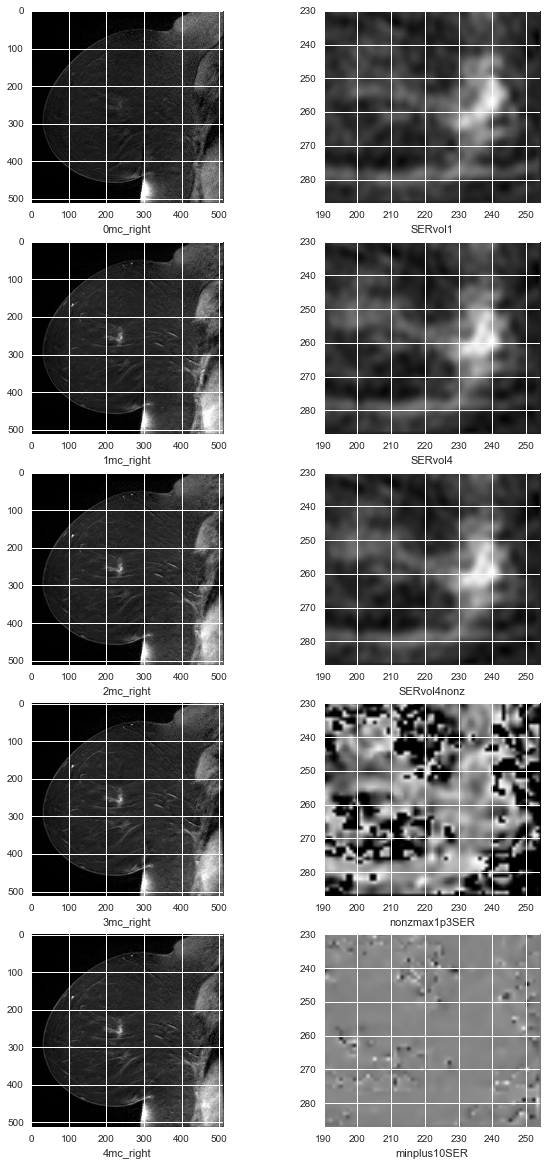

In [5]:
# Display 
import matplotlib.pyplot as plt
%matplotlib inline 
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
for k in range(5):
    ax[k,0].imshow(mriVols[k][centroid[2],:,:], cmap=plt.cm.gray)
    ax[k,0].set_adjustable('box-forced')
    ax[k,0].set_xlabel(str(k)+'mc_'+sideB)
    
ax[0,1].imshow(SERvol1, cmap=plt.cm.gray)
ax[0,1].set_adjustable('box-forced')
ax[0,1].set_xlabel('SERvol1')
ax[0,1].axis((ext_x[0], ext_x[1], ext_y[1], ext_y[0]))

ax[1,1].imshow(SERvol4, cmap=plt.cm.gray)
ax[1,1].set_adjustable('box-forced')
ax[1,1].set_xlabel('SERvol4')
ax[1,1].axis((ext_x[0], ext_x[1], ext_y[1], ext_y[0]))

ax[2,1].imshow(SERvol4nonz, cmap=plt.cm.gray)
ax[2,1].set_adjustable('box-forced')
ax[2,1].set_xlabel('SERvol4nonz')
ax[2,1].axis((ext_x[0], ext_x[1], ext_y[1], ext_y[0]))

ax[3,1].imshow(nonzmax1p3SER, cmap=plt.cm.gray)
ax[3,1].set_adjustable('box-forced')
ax[3,1].set_xlabel('nonzmax1p3SER')
ax[3,1].axis((ext_x[0], ext_x[1], ext_y[1], ext_y[0]))

ax[4,1].imshow(minplus10SER, cmap=plt.cm.gray)
ax[4,1].set_adjustable('box-forced')
ax[4,1].set_xlabel('minplus10SER')
ax[4,1].axis((ext_x[0], ext_x[1], ext_y[1], ext_y[0]))

(190, 254, 287, 230)

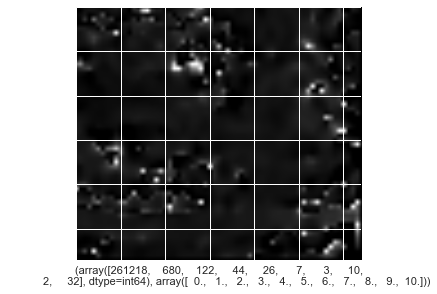

In [6]:
# explore other values for SER clipping
nonzSER =  [pix if pix > 0 else 0 for pix in SER.flatten()]
nonzmax10SER =  np.asarray([pix if pix < 10 else 10 for pix in nonzSER]).reshape(SER.shape)

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2,1,1)
ax1.imshow(nonzmax10SER, cmap=plt.cm.gray)
ax1.set_adjustable('box-forced')
ax1.set_xlabel(str( np.histogram(nonzmax10SER)))
ax1.axis((ext_x[0], ext_x[1], ext_y[1], ext_y[0]))
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1.get_yticklabels(), visible=False)
ax1.axis((ext_x[0], ext_x[1], ext_y[1], ext_y[0]))


[None, None, None, None, None, None, None]

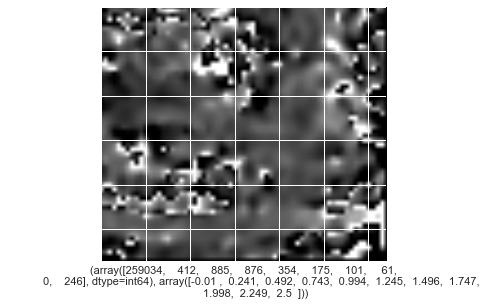

In [7]:
# accoumt for zero value pixels in the denominator
SERvol4nonz = np.asarray([pix if pix != 0.0 else 0.01 for pix in SERvol4.flatten()]).reshape(SERvol4.shape) 
# compute SER, turned off pixels will have spurious high values
SER = np.asarray(SERvol1/SERvol4nonz)
# clip extremely low and high values ( see ipython notebook for SERexploration)
# explore other values for SER clipping
nonzSER =  [pix if pix >= 0.0 else -0.01 for pix in SER.flatten()]
nonzmax1p1SER =  np.asarray([pix if pix <= 2 else 2.5 for pix in nonzSER]).reshape(SER.shape)
nonzmax1p1SER = nonzmax1p1SER.astype(np.float32)
        
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2,1,1)
ax1.imshow(nonzmax1p1SER, cmap=plt.cm.gray)
ax1.set_adjustable('box-forced')
ax1.set_xlabel(str( np.histogram(nonzmax1p1SER)))
ax1.axis((ext_x[0], ext_x[1], ext_y[1], ext_y[0]))
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1.get_yticklabels(), visible=False)


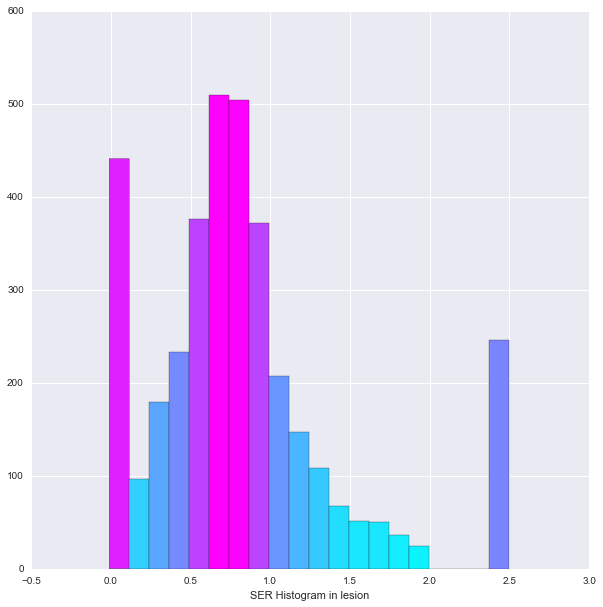

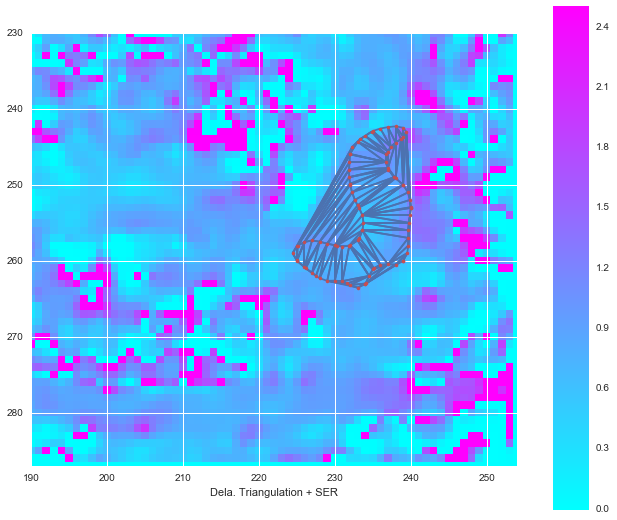

In [8]:
# SER Histogram
import matplotlib.colors
fig, ax = plt.subplots(figsize=(10, 10))
pixSER = [pix for pix in nonzmax1p1SER.ravel() if pix !=0]
N, bins, patches = ax.hist(pixSER, 20)
# we need to normalize the data to 0..1 
fracs = N.astype(float)/N.max()
norm = matplotlib.colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.cool(norm(thisfrac))
    thispatch.set_facecolor(color) 
ax.set_xlabel('SER Histogram in lesion')

# Overlay the three images
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(nonzmax1p1SER, cmap=plt.cm.cool, interpolation='none', clim=[min(nonzmax1p1SER.ravel()), max(nonzmax1p1SER.ravel())])
ax.axis((ext_x[0], ext_x[1], ext_y[1], ext_y[0]))
ax.set_adjustable('box-forced')
ax.set_xlabel('Dela. Triangulation + SER')

# Set the colormap and norm to correspond to the data for which
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

lesion_triangles = lesion_delaunay.points[lesion_delaunay.vertices]     
lines = []
# Triangle vertices
A = lesion_triangles[:, 0]
B = lesion_triangles[:, 1]
C = lesion_triangles[:, 2]
lines.extend(zip(A, B))
lines.extend(zip(B, C))
lines.extend(zip(C, A))
lines = LineCollection(lines, color='b')
ax.plot(lesion_delaunay.points[:, 0], lesion_delaunay.points[:, 1], '.r', linewidth=2)
ax.add_collection(lines)

nodeweights
Average triangle weight


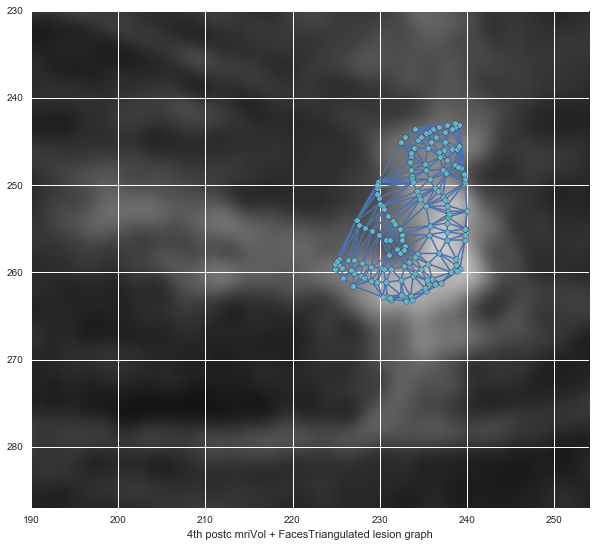

In [9]:
#########################
# 6) Calculate triangulation faces, compute faces centroid, use as new triangulation points
#########################
trianF = []
for verT in lesion_triangles:
    trianF.append( list(verT.mean(axis=0) ))

a = np.asarray( [np.asarray(trianF)[:,0], np.asarray(trianF)[:,1] ]).transpose()
trianglFaces_delaunay = Delaunay(a)

############################
###  7) Create triangulation as a nx graph, Add weights inversely proportional to SER, 
###  based on Hylton et al. 10.1200/JCO.2006.06.8080
###  if SER is high (greater than 1.1 the signal intensity decreases at post4 --> washout) --> weight =1/SER is low
###  if SER is medium (between 0.9 and 1.1 represents a plateau at post4) --> weight =1/SER is medium
###  if SER is low ( less than 0.9 indicates that signal intensity continues to rise at post4) --> weight =1/SER is High
###  minimum spanning tree M will add only links to low weight edges, to minimize total graph weigth 
#############################       
# The graph G can be grown in several ways. NetworkX includes many graph generator functions and facilities 
# get list of delaunay points        
pts = [tuple(pi.flatten()) for pi in trianglFaces_delaunay.points]            

#############################
###### 4) Sample SER at nodes
#############################
nodew = []
print "nodeweights" 
for node in pts:
    SERloc = tuple([int(loc) for loc in node])
    #print nonzmax1p1SER[SERloc[1],SERloc[0]]
    nodew.append( nonzmax1p1SER[SERloc[1],SERloc[0]] )
    
# create placeholder for nx nodes
nodes = list(range(len(pts)))
# mapping from vertices to nodes
m = dict(enumerate(nodes)) 

lesionG = nx.Graph() 
print "Average triangle weight" 
for i in range(trianglFaces_delaunay.nsimplex):
    wp1 = np.max([nodew[m[trianglFaces_delaunay.vertices[i,0]]], nodew[m[trianglFaces_delaunay.vertices[i,1]]]])
    lesionG.add_edge( m[trianglFaces_delaunay.vertices[i,0]], m[trianglFaces_delaunay.vertices[i,1]], weight = wp1 )
    wp2 = np.max([nodew[m[trianglFaces_delaunay.vertices[i,1]]], nodew[m[trianglFaces_delaunay.vertices[i,2]]]])
    lesionG.add_edge( m[trianglFaces_delaunay.vertices[i,1]], m[trianglFaces_delaunay.vertices[i,2]], weight = wp2 )
    wp3 = np.max([nodew[m[trianglFaces_delaunay.vertices[i,2]]], nodew[m[trianglFaces_delaunay.vertices[i,0]]]])
    lesionG.add_edge( m[trianglFaces_delaunay.vertices[i,2]], m[trianglFaces_delaunay.vertices[i,0]], weight = wp3 )
    #print(wp1, wp2, wp3)

# get original position of points
pos = dict(zip(nodes,pts))
# draw
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mriVols[4][centroid[2],:,:], cmap=plt.cm.gray)
ax.set_adjustable('box-forced')
ax.axis((ext_x[0], ext_x[1], ext_y[1], ext_y[0]))
nx.draw_networkx(lesionG, pos, ax=ax, with_labels=False, node_color='c',node_size=30, edge_color='b', width=1.5)
ax.set_xlabel('4th postc mriVol + FacesTriangulated lesion graph')  


all edges
[(0, 6, {'weight': 0.70900887}), (0, 78, {'weight': 0.70900887}), (0, 126, {'weight': 0.64461792}), (0, 30, {'weight': 0.64461792}), (1, 24, {'weight': 0.64824969}), (1, 117, {'weight': 0.82122856}), (1, 5, {'weight': 0.6560235}), (1, 119, {'weight': 0.77736878}), (2, 108, {'weight': 0.9271279}), (2, 10, {'weight': 0.88363826}), (2, 52, {'weight': 0.88363826}), (2, 54, {'weight': 0.81353521}), (2, 105, {'weight': 1.1682085}), (3, 24, {'weight': 0.51464438}), (3, 60, {'weight': 0.7891674}), (3, 4, {'weight': 0.50042415}), (3, 21, {'weight': 0.7891674}), (3, 65, {'weight': 0.8566398}), (4, 66, {'weight': 0.50042415}), (5, 74, {'weight': 0.91127706}), (5, 25, {'weight': 0.6560235}), (6, 80, {'weight': 0.91424131}), (6, 79, {'weight': 0.95049715}), (6, 81, {'weight': 0.91424131}), (7, 83, {'weight': 0.7441802}), (7, 29, {'weight': 0.81410152}), (7, 77, {'weight': 0.9524141}), (8, 41, {'weight': 1.1754464}), (8, 42, {'weight': 0.67320353}), (8, 43, {'weight': 0.70450735}), (9, 32,

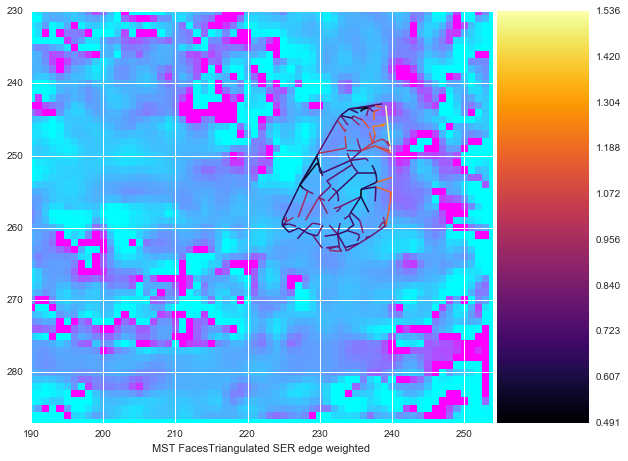

In [10]:
#############################
###### 5) Calculate minimum spanning Tree (MST)
#############################
from mpl_toolkits.axes_grid1 import make_axes_locatable

MST = nx.minimum_spanning_edges( lesionG, data=True)
edgelist = list(MST)

#Convert minimum spanning tree into graph to be able to depth searched
MST_lesionG = nx.from_edgelist(edgelist)
print "all edges"
print MST_lesionG.edges(data=True)
SER_smallw_edgelist = [(u,v,d) for (u,v,d) in MST_lesionG.edges(data=True) if d['weight'] < 200]
SER_nodeweights = [d['weight'] for (u,v,d) in MST_lesionG.edges(data=True)]

fig, ax = plt.subplots(figsize=(10, 10))
nxg = nx.draw_networkx_edges(MST_lesionG, pos, ax=ax, edge_color=SER_nodeweights, edge_cmap=plt.cm.inferno, 
                                     edge_vmin=min(SER_nodeweights),edge_vmax=max(SER_nodeweights), width=1.5)
v = np.linspace(min(SER_nodeweights), max(SER_nodeweights), 10, endpoint=True)

divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v)

ax.imshow(nonzmax1p1SER, cmap=plt.cm.cool, interpolation='none', clim=[min(nonzmax1p1SER.ravel()), max(nonzmax1p1SER.ravel())])
ax.axis((ext_x[0], ext_x[1], ext_y[1], ext_y[0]))
ax.set_xlabel('MST FacesTriangulated SER edge weighted ')

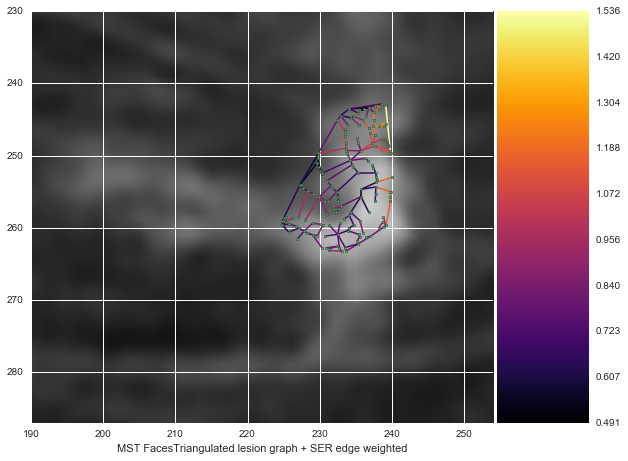

In [11]:
# Overlay with the mri image
fig, ax = plt.subplots(figsize=(10, 10))
nxg = nx.draw_networkx_edges(MST_lesionG, pos, ax=ax, edge_color=SER_nodeweights, edge_cmap=plt.cm.inferno,
    edge_vmin=min(SER_nodeweights),edge_vmax=max(SER_nodeweights), width=1.5)
nx.draw_networkx_nodes(MST_lesionG, pos, ax=ax, node_size=30, node_shape='.', node_color='g', with_labels=False)

divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v)

ax.imshow(mriVols[4][centroid[2],:,:], cmap=plt.cm.gray)
ax.axis((ext_x[0], ext_x[1], ext_y[1], ext_y[0]))
ax.set_adjustable('box-forced')
ax.set_xlabel('MST FacesTriangulated lesion graph + SER edge weighted')